In [44]:
import cv2
import imutils
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pytesseract import image_to_string
%matplotlib inline

## Functions for image output

In [3]:
def show_img(image):

    while True:
        
        cv2.imshow('Output', image)

        if cv2.waitKey(1) & 0xFF == 27:
            break
    cv2.destroyAllWindows()

In [4]:
def display_img(img, mode=None):
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    if mode == 'gray':
        ax.imshow(img, cmap='gray')
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

In [35]:
def passport_border(filename, output):
    
    # Initializing cascade
    image = cv2.imread(filename)
    #image = imutils.resize(image, width=1000)
    cascade = cv2.CascadeClassifier('cascade.xml')
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    # Finding a face
    face = cascade.detectMultiScale(gray, 1.3, 5)

    if face is not ():
        # Cutting the image so only passport was left
        (x, y, w, h) = face[0]

        (H, W, _) = image.shape

        if y - int(6 * h) < 0:
            startY = 0
        else:
            startY = y - int(6 * h)

        if y + 3 * h > H:
            endY = H
        else:
            endY = y + 3 * h

        if x - w < 0:
            startX = 0
        else:
            startX = x - w

        if x + 6 * w > W:
            endX = W
        else:
            endX = x + 6 * w

        mask = np.zeros((H, W), dtype=np.uint8)
        mask[startY:endY, startX:endX] = 255

        masked = cv2.bitwise_and(image, image, mask=mask)

        #cv2.imwrite(os.path.join('output', output + '.png'), masked)
    
    else:
        #cv2.imwrite(os.path.join('output', output + '.png'), image)
        
    return mask

## Geting random dataset

In [15]:
dataset_dir = 'dataset'

In [16]:
docs = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir)
            if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]

In [17]:
docs = random.sample(docs, 100)

## Cutting passport image

In [18]:
learning = docs[:10]

In [19]:
def rotate_passport(passport):
    """
    rotating an image so passport could be readed
    :param image: np array
    :return: np array
    """

    # Initializing cascade
    cascade = cv2.CascadeClassifier('cascade.xml')
    image = imutils.resize(passport.copy(), width=1000)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rotates = 0
    # Looking for a face
    for _ in range(4):

        face = cascade.detectMultiScale(gray, 1.3, 5)

        if face is not ():
            return imutils.rotate_bound(passport, 90 * rotates)

        gray = imutils.rotate_bound(gray, 90)
        rotates += 1

    # Return false if the given picture is not a passport
    return imutils.rotate_bound(passport, 90)

In [20]:
def get_segment_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

In [39]:
def cut_passport(filename, output):
    
    image = cv2.imread(filename)
    # image = imutils.resize(image, width=1000)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    blended = cv2.addWeighted(src1=sobelX, alpha=0.5, src2=sobelY, beta=0.5, gamma=0)
    
    kernel = np.ones((20, 20), dtype=np.uint8)
    opening = cv2.morphologyEx(blended, cv2.MORPH_OPEN, kernel)
    
    min_ = np.min(opening)
    opening = opening - min_
    max_ = np.max(opening)
    div = max_/255
    opening = np.uint8(opening / div)
    
    blurred = cv2.GaussianBlur(opening, (1, 1), 0)
    thresh = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    (h, w) = thresh.shape
    edgeH = int(h * 0.01)
    edgeW = int(w * 0.01)
    thresh[0:edgeH,0:w] = 255
    thresh[h-edgeH:h,0:w] = 255
    thresh[0:h,0:edgeW] = 255
    thresh[0:h, w-edgeW:w] = 255
    
    kernel = np.ones((20, 20), dtype=np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    inverse = cv2.bitwise_not(thresh)
    masked = get_segment_crop(image, mask=inverse)
    
    
    """
    if not os.path.exists('output1'):
        os.mkdir('output1')
    
    cv2.imwrite(os.path.join('output1', output + '.png'), masked)
    """
    
    
    return mask

In [40]:
for (i, image) in enumerate(docs):
    
    img = cv2.imread(image)
    img = rotate_passport(img)
    cv2.imwrite(image, img)
    print(i)
    
    
    mask1 = cut_passport(image, str(i))
    mask2 = passport_border(image, str(i))
    
    mask = cv2.bitwise_or()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Extracting document's edge

In [47]:
image = cv2.imread('output1/74.png', 0)

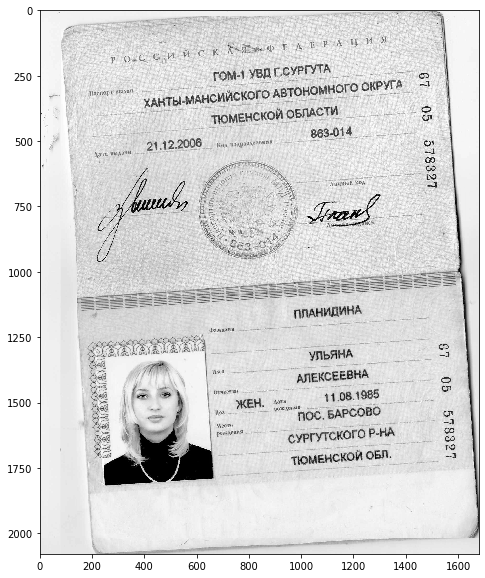

In [48]:
display_img(image, mode='gray')

In [49]:
image_to_string(image, lang='rus')

'р о-с СИ сто" Длция\n\nее | гом-1 УВД Г.СУРГУТА\nХАНТЫ-МАНСИЙСКОГО АВТОНОМНОГО ОКРУГА —\nТЮМЕНСКОЙ ОБЛАСТИ —\n21.12.2006 _ коллизия 863-014 т\n\nАата выдачи\n\nЛичный кол\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n  \n \n\nПЛАНИДИНА\n\nФамилия\n\n  \n \n \n\nХе\n\n         \n  \n\nРВ\n\nя 7 — УЛЬЯНА\n\nя (= 5 и АЛЕКСЕЕВНА\n\nм | 1 | >\n\n| |. =. 11.08.1985 сл\n\nа __ ПОС. БАРСОВО —\n\nСЗ рождения\n\n8 СУРГУТСКОГО Р-НА —\n\nС\n\nТЮМЕНСКОЙ ОБЛ. го'

In [614]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
hullImage = np.zeros(dilated.shape[:2], dtype="uint8")

In [615]:
max_area = 0
for (i, c) in enumerate(cnts):

    area = cv2.contourArea(c)

    if area > max_area:

        max_area = area

        (x, y, w, h) = cv2.boundingRect(c)

        aspectRatio = w / float(h)

        extent = area / float(w * h)

        hull = cv2.convexHull(c)
        hullArea = cv2.contourArea(hull)

        solidity = area / float(hullArea)


        output = image.copy()
        cv2.drawContours(output, [c], -1, (0, 0, 255), 3)

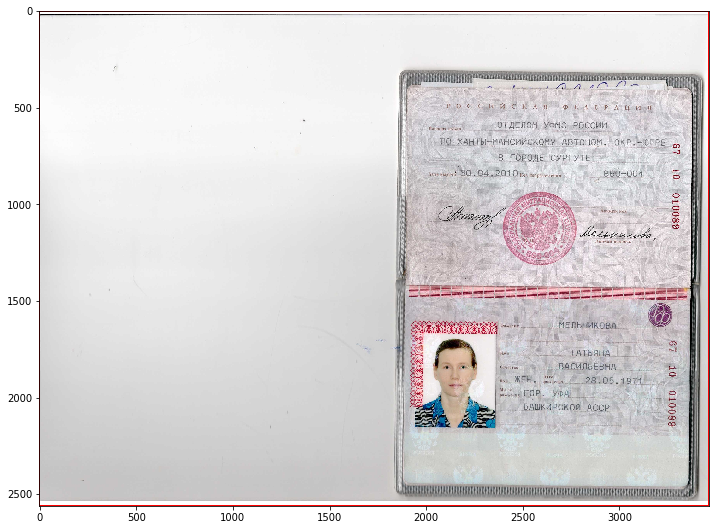

In [616]:
display_img(output)

In [3]:
print(os.listdir())

['.idea', '.ipynb_checkpoints', '84.jpeg', '87.jpeg', '88.jpeg', '89.jpeg', '93.jpeg', '94.jpeg', '98.jpeg', '99.jpeg', 'cascade.xml', 'Cutting.ipynb', 'frozen_east_text_detection.pb', 'passport.py', 'Production.ipynb', 'server.py', 'templates', 'test', 'Testing.ipynb', 'TMP', 'venv', '__pycache__']


In [4]:
image = cv2.imread('test/102.jpeg')
image = imutils.resize(image, width=1000)
cv2.imshow('Image', image)
cv2.waitKey(0)

-1

In [5]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (300, 300))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
tophat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

In [6]:
cv2.imshow('Tophat', tophat)
cv2.waitKey(0)

-1

In [7]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
                ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [8]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (150, 150))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))

gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)


In [9]:
cv2.imshow('Gradient', gradX)
cv2.waitKey(0)

-1

In [10]:
p = int(image.shape[1] * 0.05)
thresh[:, 0:p] = 0
thresh[:, image.shape[1] - p:] = 0

In [11]:
from imutils import resize

In [12]:
cv2.imshow('Thresh', resize(thresh.copy(), width=750))
cv2.imshow('Input', resize(image.copy(), width=750))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
masked = cv2.bitwise_and(image, image, mask=thresh)
cv2.imshow('Masked', masked)
cv2.waitKey(0)

-1

In [16]:
cv2.imwrite('mask.png', masked)

True